# Relacion de Flujos

In [89]:
import numpy as np
import matplotlib.pyplot as plt


# funciones relacion de flujos
def f6716_over_f6731(Ne, T): # flujos del SII
    C = 8.63e-6 / np.sqrt(T)
    A6716 = 2.6e-4
    A6731 = 8.8e-4
    return ((3 / 2) * (A6716 / A6731) * ((Ne * C + 0.26 * A6731) / (Ne * C + 0.26 * A6716)))

def f3726_over_f3729(Ne, T): # flujos del OII
    C = 8.63e-6 / np.sqrt(T)
    A3729 = 3.6e-5
    A3726 = 1.6e-4
    return (3 / 2) * (A3729 / A3726) * ((Ne * C + 1.2 * A3726) / (Ne * C + 1.2 * A3729))

# Función para coeficiente de emisión O III
def coef_OIII(Ne, T):
    term_exp = np.exp(32985 / T)
    sqrt_T = np.sqrt(T)
    numerator = (Ne / sqrt_T) + 2.6e5 * (1 + 0.12 * np.exp(-32985 / T))
    denominator = (Ne / sqrt_T) + 1627
    return 0.054 * term_exp * (numerator / denominator)

# Función para coeficiente de emisión N II
def coef_NII(Ne, T):
    term_exp = np.exp(25007 / T)
    sqrt_T = np.sqrt(T)
    numerator = (Ne / sqrt_T) + 1.3e5 * (1 + 0.12 * np.exp(-25007 / T))
    denominator = (Ne / sqrt_T) + 250.4
    return 0.01 * term_exp * (numerator / denominator)

## Exportacion SQL

In [90]:
# Exportar datos con código SQL de SQL Server (ejemplo para SDSS)
import pandas as pd
from astroquery.sdss import SDSS

# SQL multi-line string debe estar correctamente delimitado
q1 = """
SELECT TOP 10000
    s.plate,s.class, s.fiberid, s.mjd, s.z as redshift,
    s.ra, s.dec,s.bestobjid AS sdss_name,
    g.h_beta_flux, g.h_alpha_flux,
    g.oii_3726_flux,
    g.oii_3729_flux,
    g.oiii_4363_flux,
    g.oiii_4959_flux,
    g.oiii_5007_flux,
    g.sii_6717_flux,
    g.sii_6731_flux,
    g.nii_6548_flux,
    g.nii_6584_flux
FROM GalSpecLine AS g
JOIN SpecObj AS s
    ON s.specobjid = g.specobjid
WHERE
    (s.class = 'GALAXY' OR s.class = 'QSO')
    AND g.oii_3726_flux > 0
    AND g.oii_3729_flux > 0
    ANd g.oiii_4363_flux > 0
    AND g.oiii_4959_flux > 0
    AND g.oiii_5007_flux > 0
    AND g.sii_6717_flux > 0
    AND g.sii_6731_flux > 0
    AND g.nii_6548_flux > 0
    ORDER BY s.plate, s.fiberid
"""

query = q1

results = SDSS.query_sql(query)
df = results.to_pandas()
print(df.head())

   plate   class  fiberid    mjd  redshift         ra       dec  \
0    266  GALAXY        4  51630  0.064656  146.62857 -0.765137   
1    266  GALAXY       12  51630  0.055981  146.96390 -0.545003   
2    266  GALAXY       13  51630  0.097086  146.96350 -0.759352   
3    266  GALAXY       14  51630  0.064779  146.94999 -0.592202   
4    266  GALAXY       17  51630  0.064959  146.59272 -0.760256   

             sdss_name  h_beta_flux  h_alpha_flux  oii_3726_flux  \
0  1237650795146445031    25.640470      99.40005      39.057380   
1                    0    42.869560     195.51970      17.377120   
2  1237650795146641532     3.303172      21.55664       2.507094   
3                    0    60.806910     229.13250      52.756650   
4  1237650795146444862    46.948430     206.21260      39.724690   

   oii_3729_flux  oiii_4363_flux  oiii_4959_flux  oiii_5007_flux  \
0       27.09657        0.903860        9.876856        21.44437   
1       29.78789        3.899584        2.191229    

In [91]:
# contar las clases de objetos en Galaxias y QSOs en total
counts = df['class'].value_counts()
print(counts)

class
GALAXY    9652
QSO        348
Name: count, dtype: int64


In [92]:
# Seleccionar Columnas 1000 a 1990
df_eduardo = df.iloc[1000:1990].copy()

df_eduardo.loc[:, 'rate_SII']  = df_eduardo['sii_6717_flux']   / df_eduardo['sii_6731_flux']
df_eduardo.loc[:, 'rate_OII']  = df_eduardo['oii_3726_flux']   / df_eduardo['oii_3729_flux']
df_eduardo.loc[:, 'rate_OIII']= df_eduardo['oiii_5007_flux']  / df_eduardo['oiii_4363_flux']
df_eduardo.loc[:, 'rate_NII'] = df_eduardo['nii_6584_flux']   / df_eduardo['nii_6548_flux']


database = df_eduardo.reset_index(drop=True)
database.to_csv('database_eduardo.csv', index=True)

cont = df_eduardo['class'].value_counts()
print(cont)

class
GALAXY    958
QSO        32
Name: count, dtype: int64


In [93]:
# solucionar sistema de ecuaciones usando scypi
from scipy.optimize import least_squares

# -------------------- FUNCIONES SISTEMA PARA CADA CASO ----------------------

def sistema_SII_OII(vars, rate1, rate2):
    T, Ne = vars
    return [f6716_over_f6731(Ne, T) - rate1, f3726_over_f3729(Ne, T) - rate2]

def sistema_SII_OIII(vars, rate1, rate2):
    T, Ne = vars
    return [f6716_over_f6731(Ne, T) - rate1, coef_OIII(Ne, T) - rate2]

def sistema_OII_OIII(vars, rate1, rate2):
    T, Ne = vars
    return [f3726_over_f3729(Ne, T) - rate1, coef_OIII(Ne, T) - rate2]

def sistema_SII_NII(vars, rate1, rate2):
    T, Ne = vars
    return [f6716_over_f6731(Ne, T) - rate1, coef_NII(Ne, T) - rate2]

def sistema_OII_NII(vars, rate1, rate2):
    T, Ne = vars
    return [f3726_over_f3729(Ne, T) - rate1, coef_NII(Ne, T) - rate2]

# -------------------- FUNCIONES DE SOLUCIÓN ----------------------

def solve_system(sistema_func, rate1, rate2):
    try:
        x0 = [1e4, 1e2]
        sol = least_squares(lambda vars: sistema_func(vars, rate1, rate2), x0, bounds=([1000, 1], [30000, 1e6]))
        return sol.x[0], sol.x[1]
    except:
        return np.nan, np.nan

# -------------------- DICCIONARIO DE FUNCIONES ----------------------

sistemas = {
    'SII_OII': sistema_SII_OII,
    'SII_OIII': sistema_SII_OIII,
    'OII_OIII': sistema_OII_OIII,
    'SII_NII': sistema_SII_NII,
    'OII_NII': sistema_OII_NII,
}

# -------------------- APLICAR AL DATAFRAME ----------------------

def aplicar_soluciones(df, modo='SII_OII'):
    df = df.copy()

    T_list = []
    Ne_list = []

    for _, row in df.iterrows():
        try:
            r1 = row[f"rate_{modo.split('_')[0]}"]
            r2 = row[f"rate_{modo.split('_')[1]}"]
            T, Ne = solve_system(sistemas[modo], r1, r2)
        except:
            T, Ne = np.nan, np.nan
        T_list.append(T)
        Ne_list.append(Ne)

    df[f'T_e_{modo}'] = T_list
    df[f'N_e_{modo}'] = Ne_list
    return df

# -------------------- DATOS ----------------------
modos = ['SII_OII', 'SII_OIII', 'OII_OIII', 'SII_NII', 'OII_NII']
df_final = df_eduardo.copy()

for modo in modos:
    print(f"Resolviendo para: {modo}")
    df_final = aplicar_soluciones(df_final, modo=modo)
df_final.to_csv("resultados_T_Ne_todas_relaciones.csv", index=False)

Resolviendo para: SII_OII
Resolviendo para: SII_OIII
Resolviendo para: OII_OIII
Resolviendo para: SII_NII
Resolviendo para: OII_NII


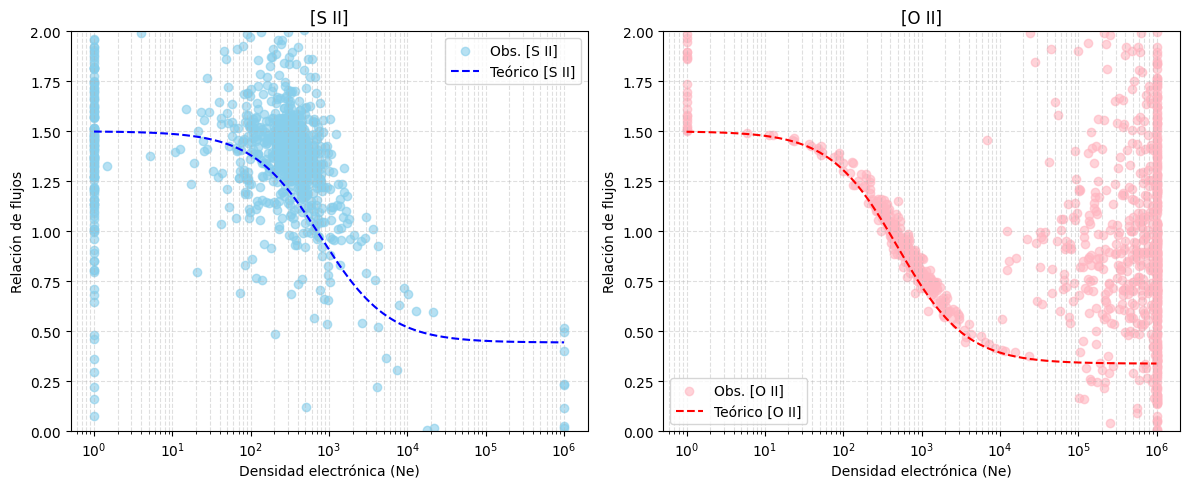

In [94]:
# funciones f6716_over_f6731 y f3726_over_f3729 ya definidas…

df = pd.read_csv("resultados_T_Ne_todas_relaciones.csv")

# extraer N_e específico para cada par
df['Ne_SII'] = df['N_e_SII_OII']      # si asumes que SII ajusta bien la N_e
df['Ne_OII'] = df['N_e_OII_OIII']     # mejor aún: define y guarda N_e_OII si lo calculaste

# ahora grafica por separado
plt.figure(figsize=(12,5))

# SII
plt.subplot(1,2,1)
mask = (df['Ne_SII']>0) & (df['rate_SII']>0)
Ne_SII = df.loc[mask,'Ne_SII']
r_SII  = df.loc[mask,'rate_SII']
plt.scatter(Ne_SII, r_SII, color='skyblue', alpha=0.6, label='Obs. [S II]')
Ne_range = np.logspace(0,6,1000)
plt.plot(Ne_range, f6716_over_f6731(Ne_range,1e4),
         '--', color='blue', label='Teórico [S II]')
plt.xscale('log'); plt.ylim(0,2); plt.title('[S II]'); plt.legend(); plt.grid(which='both',ls='--',alpha=0.4)
plt.xlabel('Densidad electrónica (Ne)')
plt.ylabel('Relación de flujos')

# OII
plt.subplot(1,2,2)
mask = (df['Ne_OII']>0) & (df['rate_OII']>0)
Ne_OII = df.loc[mask,'Ne_OII']
r_OII  = df.loc[mask,'rate_OII']
plt.scatter(Ne_OII, r_OII, color='lightpink', alpha=0.6, label='Obs. [O II]')
plt.plot(Ne_range, f3726_over_f3729(Ne_range,1e4),
         '--', color='red', label='Teórico [O II]')
plt.xscale('log'); plt.ylim(0,2); plt.title('[O II]'); plt.legend(); plt.grid(which='both',ls='--',alpha=0.4)
plt.xlabel('Densidad electrónica (Ne)')
plt.ylabel('Relación de flujos')

plt.tight_layout()
plt.show()


Las posibles diferencias entre el modelo teorico y las mediciones obtenidas para los mismo indices en distintas galaxias se puede deber a diferentes razones, entre las principales al tipo de clasificacion del AGN en las galaxias que poseen AGN, una opcion seria graficar solo QSOs y verificar si hay un mejor comportamiento respecto a la curva teorica, debido a que los cuásares (QSOs) tienden a mostrar núcleos más luminosos y, a menudo, líneas de emisión más anchas, lo que puede sesgar la estimación de Ne y T. En cambio, los núcleos Seyfert habitualmente tienen condiciones de densidad y temperatura más parecidas a las asumidas en los modelos “uniformes” para lo cual seria interesante revisar  si se pueden comparar solo galaxias tipo Seyfert es decir si la inclinacion del objeto tiene influencia.

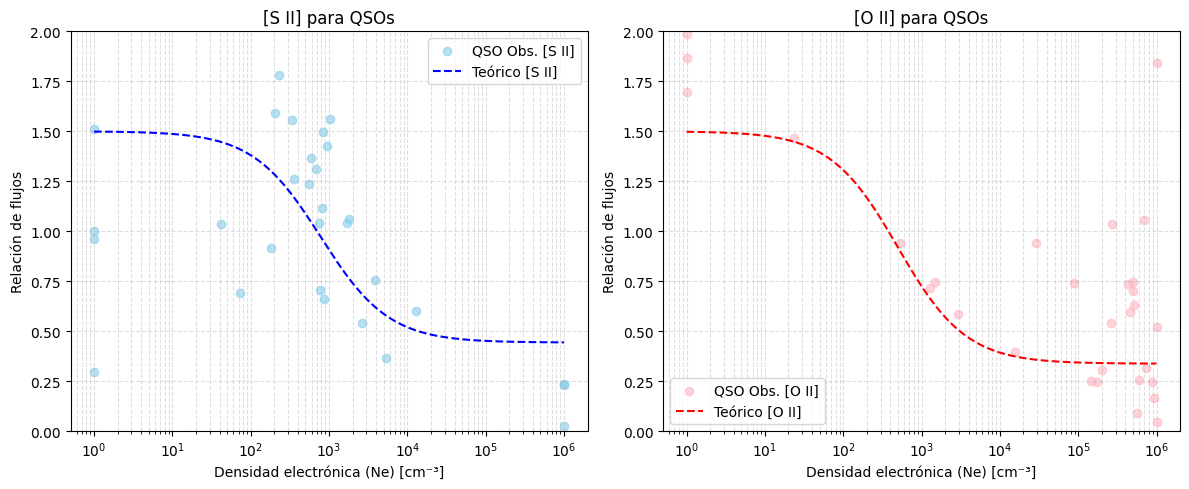

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Cargar datos
df = pd.read_csv("resultados_T_Ne_todas_relaciones.csv")

# 2) Filtrar para quedarnos solo con QSOs
df_qso = df[df['class'] == 'QSO'].copy()

# 3) Extraer N_e específico para cada par
#    Aquí usamos tu nomenclatura: Ne_SII desde SII_OII y Ne_OII desde OII_OIII
df_qso['Ne_SII'] = df_qso['N_e_SII_OII']
df_qso['Ne_OII'] = df_qso['N_e_OII_OIII']

# 4) Rango para curva teórica
Ne_range = np.logspace(0, 6, 1000)
T_fixed = 1e4

# 5) Graficar en subplots
plt.figure(figsize=(12, 5))

# --- [S II] ---
plt.subplot(1, 2, 1)
mask_sii = (df_qso['Ne_SII'] > 0) & (df_qso['rate_SII'] > 0)
plt.scatter(
    df_qso.loc[mask_sii, 'Ne_SII'],
    df_qso.loc[mask_sii, 'rate_SII'],
    color='skyblue', alpha=0.6, label='QSO Obs. [S II]'
)
plt.plot(
    Ne_range,
    f6716_over_f6731(Ne_range, T_fixed),
    '--', color='blue', label='Teórico [S II]'
)
plt.xscale('log')
plt.ylim(0, 2)
plt.title('[S II] para QSOs')
plt.xlabel('Densidad electrónica (Ne) [cm⁻³]')
plt.ylabel('Relación de flujos')
plt.legend()
plt.grid(which='both', ls='--', alpha=0.4)

# --- [O II] ---
plt.subplot(1, 2, 2)
mask_oii = (df_qso['Ne_OII'] > 0) & (df_qso['rate_OII'] > 0)
plt.scatter(
    df_qso.loc[mask_oii, 'Ne_OII'],
    df_qso.loc[mask_oii, 'rate_OII'],
    color='lightpink', alpha=0.6, label='QSO Obs. [O II]'
)
plt.plot(
    Ne_range,
    f3726_over_f3729(Ne_range, T_fixed),
    '--', color='red', label='Teórico [O II]'
)
plt.xscale('log')
plt.ylim(0, 2)
plt.title('[O II] para QSOs')
plt.xlabel('Densidad electrónica (Ne) [cm⁻³]')
plt.ylabel('Relación de flujos')
plt.legend()
plt.grid(which='both', ls='--', alpha=0.4)

plt.tight_layout()
plt.show()


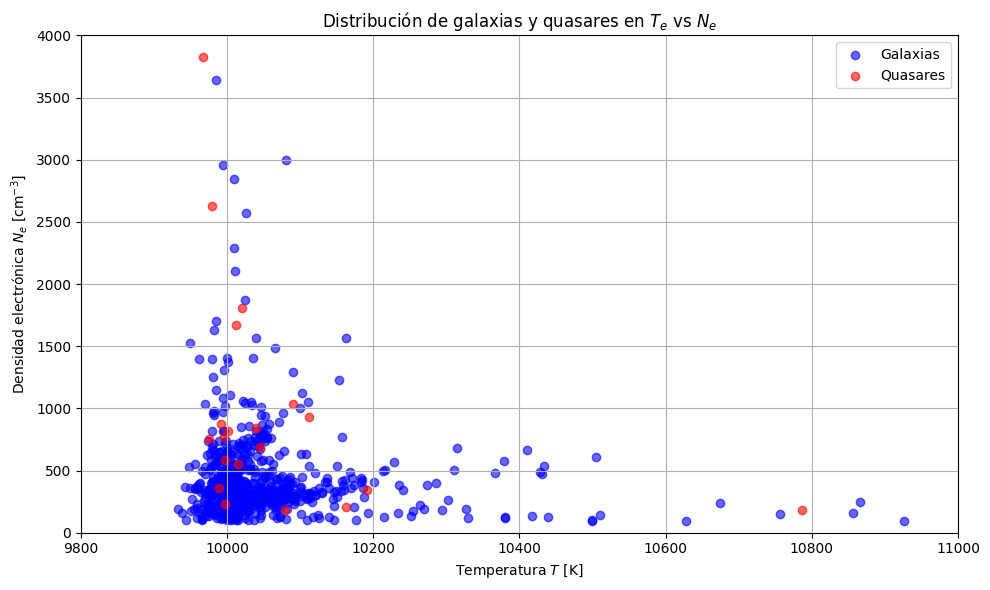

In [99]:
df = pd.read_csv("resultados_T_Ne_todas_relaciones.csv")


df_plot = df[['class', 'T_e_SII_OII', 'N_e_SII_OII']].dropna()


colors = {'GALAXY': 'blue', 'QSO': 'red'}


plt.figure(figsize=(10, 6))
for obj_type, group in df_plot.groupby('class'):
    plt.scatter(
        group['T_e_SII_OII'],
        group['N_e_SII_OII'],
        color=colors.get(obj_type, 'gray'),
        label='Galaxias' if obj_type == 'GALAXY' else 'Quasares',
        alpha=0.6
    )


plt.xlabel("Temperatura $T$ [K]")
plt.ylabel("Densidad electrónica $N_e$ [cm$^{-3}$]")
plt.ylim(0,4000)
plt.xlim(9800,11000)
plt.title("Distribución de galaxias y quasares en $T_e$ vs $N_e$")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
